In [1]:
# Import relevant libraries
include("./math405.jl")

 Activating environment at `~/Desktop/Symplectic-Integrators/src/Project.toml`


In [8]:
function _iterate(f, u0, h, Tf, stepper; kwargs...)
    t = 0:h:Tf
    U = zeros(length(u0), length(t))
    U[:, 1] = u0
    for n = 2:length(t)
        U[:, n] = stepper(U[:,n-1], f, h; kwargs...)
    end 
    return U, t
end  

u2rv(u) = (n = length(u)÷4; (reshape(u[1:2*n], (2, n)), reshape(u[2*n+1:end], (2, n))))
rv2u(r, v) = [r v][:]


# For Simple Harmonic Oscillators
function explicit_euler_step(u, f, h)   
    n = length(u) ÷ 2
    r, v = u[1:n], u[n+1:end]
    r1 = r + h * v 
    v1 = v + h * f(r)
    return rv2u(r1, v1)
end

function eulerA_step(u, f, h)   
    n = length(u) ÷ 2
    r, v = u[1:n], u[n+1:end]
    r = r + h * v 
    v = v + h * f(r)
    return rv2u(r, v)
end

function verlet_step(u, f, h)
    n = length(u) ÷ 2
    r, v = u[1:n], u[n+1:end]
    v = v + f(r) * h * 0.5
    r = r + v * h
    v = v + f(r) * h * 0.5
    return rv2u(r, v)
end

function verlet_step(u, f, h)
    n = length(u) ÷ 2
    r, v = u[1:n], u[n+1:end]
    v = v + f(r) * h * 0.5
    r = r + v * h
    v = v + f(r) * h * 0.5
    return rv2u(r, v)
end

explicit_euler_method(f, u0, h, Tf) = _iterate(f, u0, h, Tf, explicit_euler_step)
eulerA_method(f, u0, h, Tf) = _iterate(f, u0, h, Tf, eulerA_step)
verlet_method(f, u0, h, Tf) = _iterate(f, u0, h, Tf, verlet_step)

# For plotting needs below
func_cos1(x)= cos(x)/2
func_sin1(x) = sin(x)/2
func_cos2(x)= cos(x)/2.5
func_sin2(x) = sin(x)/2.5
func_cos3(x)= cos(x)*1.5
func_sin3(x) = sin(x)*1.5

func_sin3 (generic function with 1 method)

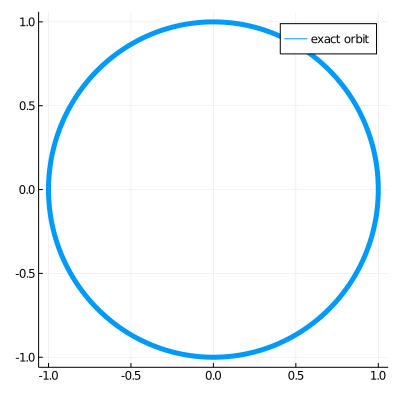

In [3]:
harmosc(u, c=1.0) = [u[2], - c * u[1]]
u0 = [1.0, 0.0]
h = 0.1
Tf = 6 * π

plt1 = plot(cos, sin, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))

## Introduction to Symplectic Integrators

Symplectic methods belong to a larger class of *geometric numerical integrators*. These algorithms preserve geometric properties inherent in the system. As a quick primer, in the case of symplectic integrators, these methods preserve the sympletic structure inherent in the phase space representation of the dynamics of the problem.

Now the precise definition of "symplectic" is rather involved. Wikipedia defines symplectic problems as problem's whose solution lies on a symplectic manifold where symplectic manifold is defined as "smooth manifold equipped with a closed non-degenerate differential 2 form." This rather archaic so I'll attempt to explore this be observing the consequences of symplecity.


**Identifying Symplectic Integrators**

There are a variety of ways of assessing if an integrator/problem is symplectic. In order to better understand this process we first need to better understand what we are trying to do by solving a Hamiltonian system.

Recall that when solving a Hamiltonian system ($H = T(p)+V(q)$) what we are trying to obtain is an expression for $p(t)$ and $q(t)$. If we plot $p$ against $q$ what we obtain is a "phase-space" plot as shown below for a simple harmonic oscillator.

So in essence, phase-space represents all possible states (i.e. $(p,q)$) of the system given the constraints. The natural consequence for Hamiltonian systems is that energy is conserved in all points on the phase-space.

Now, given different initial conditions, the total energy of the system could vary leading to different phase spaces.  Each ring in the plot below represents a distinct phase space defined by the intial condition and the specific Hamiltonian.


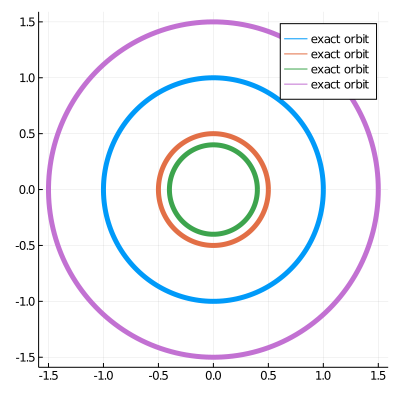

In [4]:
ps_plt = plot(cos, sin, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))
plot!(ps_plt, func_cos1, func_sin1, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))
plot!(ps_plt, func_cos2, func_sin2, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))
plot!(ps_plt, func_cos3, func_sin3, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))

So, by solving a Hamiltonian system, you are creating a mapping between initial conditions and the phase space. We call this mapping "phase flow."
$$
f: (p_0,q_0) \rightarrow (p(t),q(t))
$$

***

Now, we can formally verify if the problem is symplectic. If the following expression evaluates to be true the problem is symplectic. $f'(Z)$ here is the jacobian of the phase flow outlined above and $J$ is called the symplectic matrix which is defined to be just [[0,1],[-1,0]] for the case of the Hamiltonian.

$$
f'(z)^TJf'(z) = J
$$

We'll use this shortly on a series of Euler Methods. Hopefully that will make the process more clear.

Alternatively, we can delve into the consequences of integrators being symplectic. In particular we can look into **Preservation of Phase-Space Volume**.

Since we know what phase-space is now, let's try to connect this to phase-space volume. If this statement $f'(z)^TJf'(z) = J$ holds, it implies that the determinant of the Jacobian is 1. The natural consequence of this is that the phase-space volume is preserved.
$$
det(f'(z)) = 1
$$

In the case of the simple harmonic oscillator that we'll be looking at below. The dimension is one so the volume collapses to a phase space area. We'll look at this visually below.

If the phase flow of the problem demonstrates the aforementioned "symplectic" property the problem is symplectic. Similarly, if the phase flow approximated by the integrator demonstrates the aforemented property the integrator is a "symplectic integrator."

It turns out that Hamiltonian Systems are "symplectic," making them a good candidate to be be solved using symplectic integrators.

**Quick Aside:** The order of numerical integrators. For methods of order n,  $u_{t+1} - U(t_0+\Delta t) = O(t^{n+1})$ as $\Delta t \rightarrow 0$ 

### Explicit/Implicit Euler Method

Let's start with what we've already explored in class. We'll revisit the harmonic oscillator whose Hamiltonian is defined as follows: $H = \frac{1}{2}q^2+\frac{1}{2}p^2$. The constant terms will be neglected for the time being for simplicity. 

Both explicit (forward) or implicit (backward) euler methods can be used to solve the Hamiltonian system for trajectories of $p$ and $q$. However, as we are already aware both of these methods do not conserve total energy. As shown in the equations below, the numerical solution diverges from the true solution - **quadratically** in the case of the harmonic oscillator shown below.

$$
    H_{n+1}
    =
    \begin{cases}
        (1+h^2) H_n, & \text{Explicit Euler method}  \\
        \frac{1}{1+h^2} H_n, & \text{Implicit Euler method} 
    \end{cases}
$$

*Quick Derivation:*
$$
\text{Explicit Euler Method}
    =
\begin{cases}
q_{t+1} = q_t + p_t h \\
p_{t+1} = p_t - q_t h
\end{cases}
$$

$$\begin{aligned}
H_{t+1} - H_t &= \frac{1}{2}\left( q_{t+1}^2-q_t +p_{t+1}^2-p_t \right) \\
&= \frac{1}{2}\left( (q_t + p_t h)^2-q_t + (p_t -q_t h)^2-p_t \right) \\
&= \frac{1}{2}\left( p_t^2h^2 + q_t^2h^2 \right) \\
&= \frac{1}{2}(p_t^2 + q_t^2)h^2 \\
&= H_t h^2 \\
H_{t+1} &= (1+h^2) H_t
\end{aligned}$$

Similarly we can obtain the expression for Implicit Euler Method.

It's worth noting that in the case of the explicit euler method the system creates energy while the implicit euler method dissipate energy. Also, having explored the formal definition of symplectic integrators above, we can verify that both of these Euler methods are indeed not symplectic.


Explicit Euler Method can be expressed in matrix form.
$$
\begin{bmatrix}
q_{t+1} \\
p_{t+1} 
\end{bmatrix}
=
\begin{bmatrix}
1 & \Delta t \\
-\Delta t & 1
\end{bmatrix}
\begin{bmatrix}
q_{t} \\
p_{t} 
\end{bmatrix}
$$

$$
f'(z)^TJf'(z) =
\begin{bmatrix}
1 & \Delta t \\
-\Delta t & 1
\end{bmatrix}^T
\begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}
\begin{bmatrix}
1 & \Delta t \\
-\Delta t & 1
\end{bmatrix}
=
\begin{bmatrix}
0 & 1+\Delta t^2 \\
-(1+\Delta t^2) & 0
\end{bmatrix}
\text{ (Not symplectic)}
$$

plt2 = Plot{Plots.GRBackend() n=2}


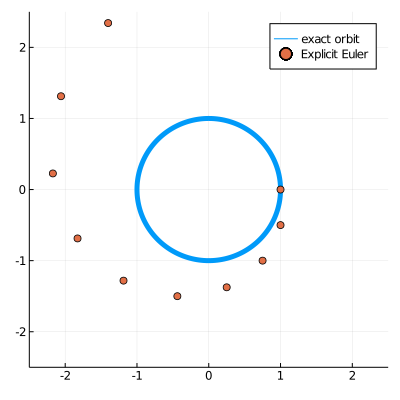

In [5]:
Uee, tee = explicit_euler_method(r -> -r, [1.0,0.0], 0.5, 6π) 
plt2 = plot(cos, sin, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))
scatter!(plt2, Uee[1,:], Uee[2,:], label = "Explicit Euler", xlims=(-2.5, 2.5), ylims = (-2.5, 2.5));
@show plt2

plt3 = Plot{Plots.GRBackend() n=22}


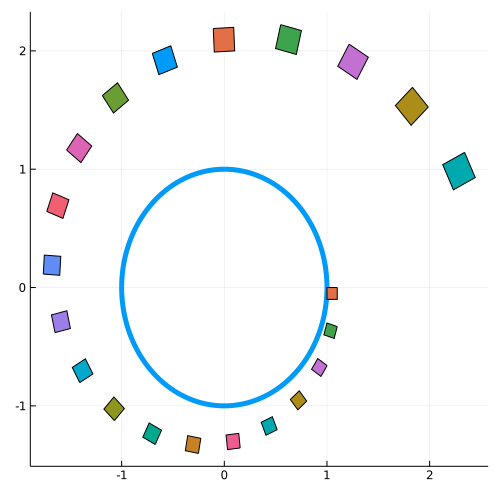

In [6]:
# Let's look at the phase area
step_size = 0.3
Uee_1, tee_1 = explicit_euler_method(r -> -(r), [1.1, 0.0], step_size, 2*π)
Uee_2, tee_2 = explicit_euler_method(r -> -(r), [1.1, -0.1], step_size, 2*π)
Uee_3, tee_3 = explicit_euler_method(r -> -(r), [1.0, -0.1],step_size, 2*π)
Uee_4, tee_4 = explicit_euler_method(r -> -(r), [1.0, 0.0], step_size, 2*π)

plt3 = plot(sin, cos, 0, 2*π, lw=5, label=false, size = (500,500))

for i in 1:size(tee_4)[1]
    plot!(Shape([(Uee_1[1,i], Uee_1[2,i]), (Uee_2[1,i], Uee_2[2,i]), (Uee_3[1,i], Uee_3[2,i]), (Uee_4[1,i], Uee_4[2,i])]), labels=false);
end

@show plt3

### Symplectic Euler Method

Combining explicit and implicit methods can yield symplectic integrators. In order to produce symplectic euler method, we can write $q$ in explicit form  and $p$ in implicit form or vice versa. Each approach leads to Euler-A and Euler-B methods respectively.

Euler-B

$$\begin{aligned}
      q_{i+1} &= q_i + h p_{i+1} \\ 
      p_{i+1} &= p_i - h q_{i}
\end{aligned}$$

Euler-B Method can be expressed in matrix form.
$$
\begin{bmatrix}
q_{t+1} \\
p_{t+1} 
\end{bmatrix}
=
\begin{bmatrix}
1-\Delta t^2 & \Delta t \\
-\Delta t & 1
\end{bmatrix}
\begin{bmatrix}
q_{t} \\
p_{t} 
\end{bmatrix}
$$

$$
f'(z)^TJf'(z) =
\begin{bmatrix}
1-\Delta t^2 & \Delta t \\
-\Delta t & 1
\end{bmatrix}^T
\begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}
\begin{bmatrix}
1-\Delta t^2 & \Delta t \\
-\Delta t & 1
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}
\text{ (Symplectic)}
$$


plt1 = Plot{Plots.GRBackend() n=2}


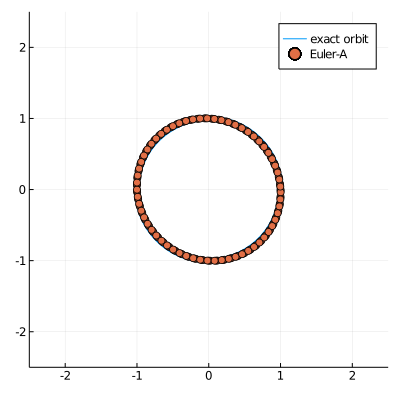

In [9]:
Ua, ta = eulerA_method(r -> -r, [1.0,0.0], 0.1, 6π) 
scatter!(plt1, Ua[1,:], Ua[2,:], label = "Euler-A", xlims=(-2.5, 2.5), ylims = (-2.5, 2.5));

@show plt1

plt4 = Plot{Plots.GRBackend() n=22}


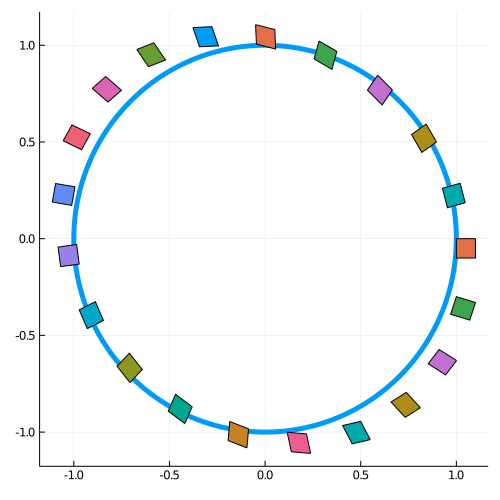

In [11]:
Ua_1, ta_1 = eulerA_method(r -> -(r), [1.1, 0.0], 0.3, 2*π)
Ua_2, ta_2 = eulerA_method(r -> -(r), [1.1, -0.1], 0.3, 2*π)
Ua_3, ta_3 = eulerA_method(r -> -(r), [1.0, -0.1], 0.3, 2*π)
Ua_4, ta_4 = eulerA_method(r -> -(r), [1.0, 0.0], 0.3, 2*π)

plt4 = plot(sin, cos, 0, 2*π, lw=5, label=false, size = (500,500))

for i in 1:size(ta_4)[1]
    plot!(Shape([(Ua_1[1,i], Ua_1[2,i]), (Ua_2[1,i], Ua_2[2,i]), (Ua_3[1,i], Ua_3[2,i]), (Ua_4[1,i], Ua_4[2,i])]), labels=false);
end

@show plt4

**Shadow Hamiltonian**

So, as we've explored in Assignment 3, if the shawdow hamiltonian is preserved, we can place a bound on the periodic perturbations of the exact hamiltonian ($H$). This is an important property of symplectic integrators that make them well-suited for long-term integration. For higher order methods the following is true ($H'(p,q)$ represents the shadow hamiltonian.)

$$
H′(p,q)=H(p,q)+O(\Delta t^n)
$$

But some may have ask:
   * Where does the expression for the shawdow hamiltonian come from? Does it differ for each method used?
   * How is this related to the symplectic property of these integrators?
   
Unfortunately, the answer to these questions are slightly more involved. However, we'll leave some pointers here for those that want to explore further.

The essence of it is that it comes from the "Baker–Campbell–Hausdorff formula" which yields an exact expression for the transformations that represents the specific method used. The expression for the shadow hamiltonian includes the exact hamiltonian and it's the remaining terms that bound the periodic perturbations. 

For instance for order 1 methods $H′(p,q)=H_0(p,q)+H_1(p,q)\Delta t$.

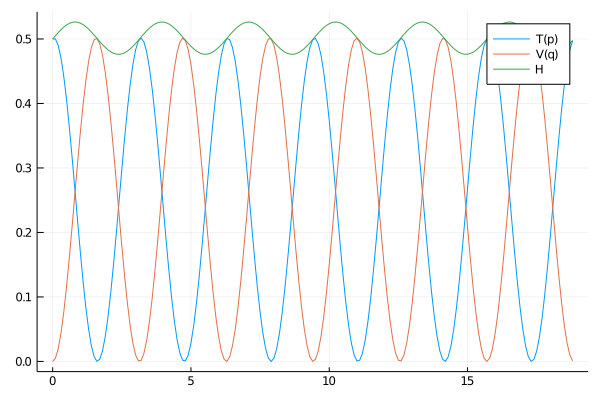

In [12]:
Ha = [ 0.5*norm(u)^2 for u in eachcol(Ua)]
r = [0.5*U^2 for U in Ua[1,:]]
v = [0.5*U^2 for U in Ua[2,:]]
plot(ta, r, label="T(p)")
plot!(ta, v, label="V(q)")
plot!(ta, Ha, label="H")

### Quick Summary before we introduce other Symplectic Integrators

* Given a symplectic problem (notably Hamiltonian systems) you would use symplectic integrators in situations where **long-term integration** is required. Note that energy isn't exactly conserved due to periodicity.
    * If very high accuracy is needed "normal" integrators such as adaptive RK methods are worth considering.
* The alternative is to use a very accurate method (adaptive methods fare reasonably well). The energy would drift due to the lack of periodicity, but the margin will be small due to high accuracy.
* In terms of computational efficiency, it's worth exploring/benchmarking both options for the particular usecase.

## Verlet ( Leapfrog) Method
### Intuition behind the Verlet/Leapfrog Method

At each step of the Euler method we would approximate,

$$q_{n+1} = q_{n} + h p_{n} \quad (1)$$ 
$$p_{n+1} = p_n + h F(q_n) \quad (2)$$

A better approximation for $q_{n+1}$ and $p_{n+1}$ would be,

$$q_{n+1} = q_{n} + h p_{n + \frac{1}{2}}$$
$$p_{n+1} = p_{n} + h F(q_{n + \frac{1}{2}})$$

However we do not know $p_{n + \frac{1}{2}}$ or $q_{n + \frac{1}{2}}$. For know let us assume we do know $p_{n + \frac{1}{2}}$, then we can have the following basic integration formula,

$$q_{n+1} = q_{n} + h p_{n + \frac{1}{2}} \quad (3)$$
$$p_{n+\frac{3}{2}} = p_{n + \frac{1}{2}} + h F(q_{n + 1}) \quad (4)$$

This highlights why this method is known as leapfrog,


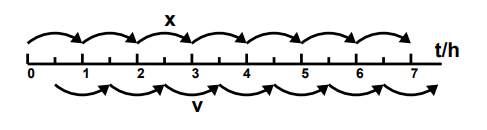

We would need $p_{\frac{1}{2}}$ as an initial condition to use the above integration formulas. We can approximate $p_{\frac{1}{2}}$ using a half Euler step at the very begining,

$$p_{\frac{1}{2}} = p_0 + \frac{1}{2}h F(q_0)$$

To get $p$ at the same time as $q$, we can consider $(4)$ to be made up of two equal half steps, were a single step would be,

$$p_{n+\frac{1}{2}} = p_{n} + \frac{1}{2}h F(q_n)$$
$$q_{n+1} = q_{n} + h p_{n+\frac{1}{2}}$$
$$p_{n+1} = p_{n+\frac{1}{2}} + \frac{1}{2} h F(q_{n+1})$$

Hence we get the following step function,


In [13]:
function verlet_step(u, f, h)
    n = length(u) ÷ 2
    q, p = u[1:n], u[n+1:end]
    p = p + f(q) * h * 0.5
    q = q + p * h
    p = p + f(q) * h * 0.5
    return rv2u(q, p)
end

verlet_method(f, u0, h, Tf) = _iterate(f, u0, h, Tf, verlet_step)

verlet_method (generic function with 1 method)

verlet_plt = Plot{Plots.GRBackend() n=2}


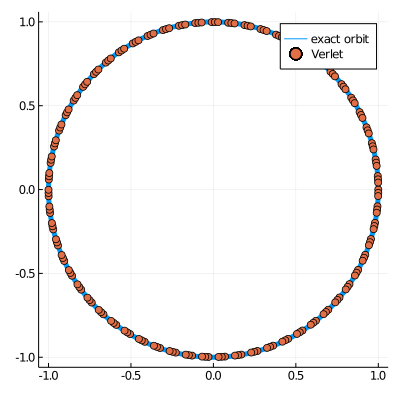

In [14]:
Uv, tv = verlet_method(q -> -q, [1.0,0.0], 0.1, 6*π)
verlet_plt = plot(cos, sin, 0, 2*π, lw=5, label = "exact orbit", size = (400,400))
scatter!(verlet_plt, Uv[1,:], Uv[2,:], label = "Verlet");

@show verlet_plt

### Is Verlet Method symplectic?

Phase plane volume is preserved:

plt2 = Plot{Plots.GRBackend() n=22}


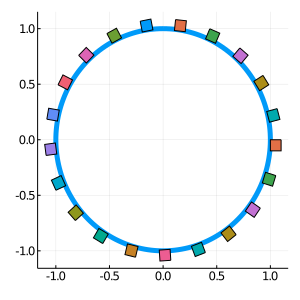

In [15]:
Uv_1, tv_1 = verlet_method(r -> -(r), [1.1, 0.0], 0.3, 2*π)
Uv_2, tv_2 = verlet_method(r -> -(r), [1.1, -0.1], 0.3, 2*π)
Uv_3, tv_3 = verlet_method(r -> -(r), [1.0, -0.1], 0.3, 2*π)
Uv_4, tv_4 = verlet_method(r -> -(r), [1.0, 0.0], 0.3, 2*π)

plt2 = plot(sin, cos, 0, 2*π, lw=5, label=false, size = (300,300))

for i in 1:size(tv_4)[1]
    plot!(Shape([(Uv_1[1,i], Uv_1[2,i]), (Uv_2[1,i], Uv_2[2,i]), (Uv_3[1,i], Uv_3[2,i]), (Uv_4[1,i], Uv_4[2,i])]), labels=false);
end

@show plt2

Hamiltonian is bounded:

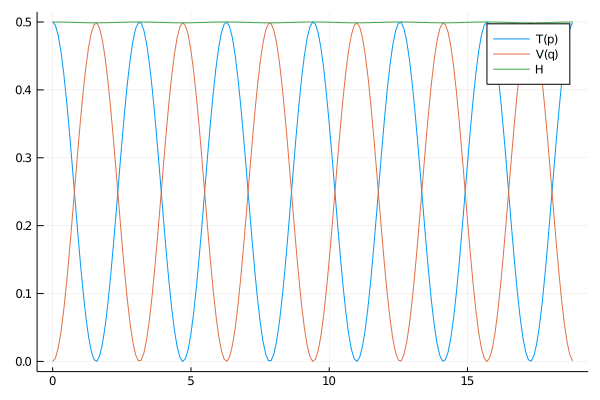

In [16]:
Hv = [ 0.5*norm(u)^2 for u in eachcol(Uv) ]
r = [0.5*U^2 for U in Uv[1,:]]
v = [0.5*U^2 for U in Uv[2,:]]
plot(tv, r, label="T(p)")
plot!(tv, v, label="V(q)")
plot!(tv, Hv, label="H")

### Order of the Verlet Method

Reviewing our intergration formulas,

$$q_{n+1} = q_{n} + h p_{n + \frac{1}{2}} \quad (3)$$
$$p_{n+\frac{3}{2}} = p_{n + \frac{1}{2}} + h F(q_{n + 1}) \quad (4)$$

This seems to be first order however the above equations can be expressed as,

$$q_{n+1} = q_{n} + h p_{n} + \frac{1}{2}F(q_n)h^2 \quad (5)$$
$$p_{n+1} = p_{n} + \frac{1}{2} (F(q_n) + F(q_{n + 1})) h \quad (6)$$

Now notice that equation (5) is similar to the second order Taylor series.

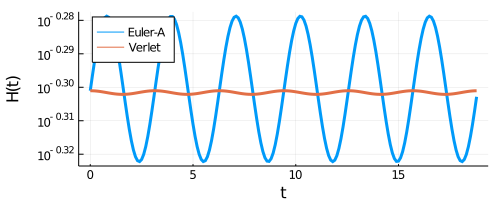

In [17]:
Ha, Hv = tuple([ [ 0.5*norm(u)^2 for u in eachcol(U) ] for U in (Ua, Uv) ]...)

plot(tv, Ha, yaxis = :log10, lw=3, label = "Euler-A", size = (500, 200), legend = :topleft)
plot!(tv, Hv, label = "Verlet", lw=3, xlabel = "t", ylabel = "H(t)")

### Examples of solving Kepler problem with Verlet Method

In [18]:
function verlet_kepler_step(u, h, H)
    n = length(u) ÷ 2
    r, v = u[1:n], u[n+1:end]
    
    pdot(q,p) = ForwardDiff.gradient(q->-H(q, p), q)
    qdot(q,p) = ForwardDiff.gradient(p-> H(q, p), p)
    
    v = v + pdot(r,v) * h * 0.5
    r = r + v * h
    v = v + pdot(r,v) * h * 0.5
    return rv2u(r, v)
end

function verlet_kepler(u0, h, Tf, H)
    t = 0:h:Tf
    U = zeros(length(u0), length(t))
    U[:, 1] = u0
    for n = 2:length(t)
        U[:, n] = verlet_kepler_step(U[:,n-1], h, H)
    end 
    return U, t
end  

verlet_kepler (generic function with 1 method)

Kepler problem is a special case of the two-body problem. It has Hamiltonian H and angular momentum L,

$$H = \frac{1}{2}||p||^2 - \frac{1}{||q||},\quad L = q_1p_2 - q_2p_2$$

Where both of these quantities are conserved. Also as it is also Hamiltonian we also know that,

$$\frac{dp}{dt} = -\frac{\delta H}{\delta q},\quad \frac{dq}{dt} = \frac{\delta H}{\delta p}$$

In [20]:
# Define the Hamiltonian
H(q,p) = norm(p)^2/2 - inv(norm(q))
AngM(q,p) = q[1]*p[2] - p[1]*q[2]

pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-H(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> H(q, p), p)

q0 = [0.4, 0.0]
p0 = [0.0, 2.0]

using OrdinaryDiffEq

initial_cond = (q0, p0)
initial_first_integrals = (H(initial_cond...), AngM(initial_cond...))
tspan = (0,30.)
prob = DynamicalODEProblem(pdot, qdot, p0, q0, tspan)
sol = solve(prob, VerletLeapfrog(), dt=0.01);

plt_kepler = Plot{Plots.GRBackend() n=1}


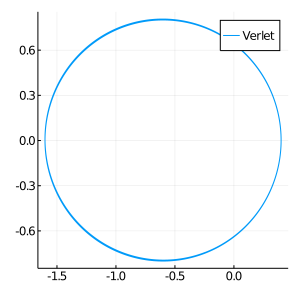

In [21]:
Uv,tv = verlet_kepler(vcat(q0,p0), 0.01, 100, H)
plt_kepler = plot(Uv[1,:], Uv[2,:], label = "Verlet", size=(300,300));
@show plt_kepler

In [22]:
plot_orbit(sol) = plot(sol,vars=(2,1))

function plot_first_integrals(sol, H, L)
    plot(initial_first_integrals[1].-map(u->H(u[2,:], u[1,:]), sol.u), lab="Hamiltonina")
    plot!(initial_first_integrals[2].-map(u->L(u[2,:], u[1,:]), sol.u), lab="Angular Momentum")
end
analysis_plot(sol, H, L) = plot(plot_orbit(sol), plot_first_integrals(sol, H, L))

analysis_plot (generic function with 1 method)

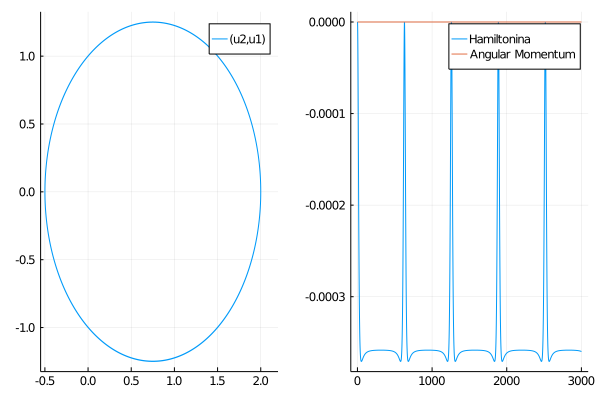

In [23]:
analysis_plot(sol, H, AngM)

sol2.u |> length = 74


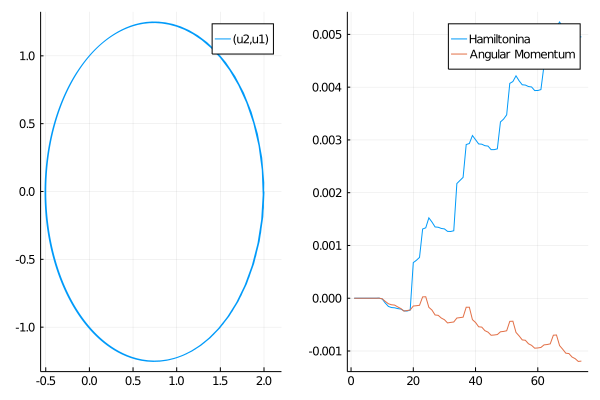

In [24]:
sol2 = solve(prob, Tsit5())
@show sol2.u |> length
analysis_plot(sol2, H, AngM)

## Solving Hamiltonian PDEs with Symplectic Integrators

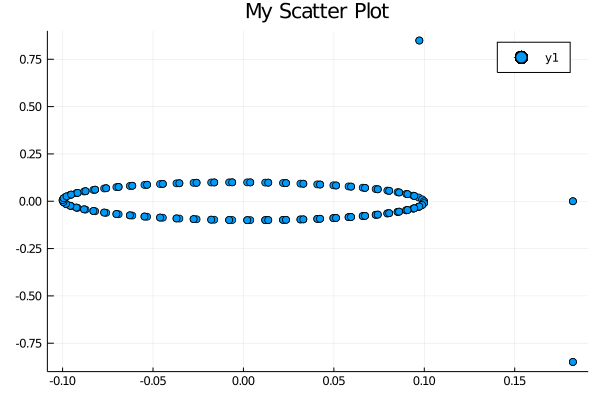

In [181]:
# Solving the Wave Equation
# Note: this cell is just for my reference. Feel free to skip over it. Will

# Defining constants
h = 0.1
L = 2*pi

# Boundary conditions
u0, uL = 0, 0

# Initial condition
f(x) = sin(x)
steps = [0+h:h:L-h;]
u_init = f.(steps)

q_init = u_init
p_init = steps*0

# Define 2nd derv. matrix
n = length(steps)
lol = zeros(n, n)
lol[diagind(lol)] .= 2
lol[diagind(lol, 1)] .= -1
lol[diagind(lol, -1)] .= -1
lol = (1/h^2) .* lol

Uv_1, tv_1 = eulerA_method(r -> -lol * r, vcat(q_init, p_init), 0.1, 20)

plot(Uv_1[1,:], Uv_1[1+n,:], seriestype = :scatter, title = "My Scatter Plot")

### Wave Equation

Linear wave equation is a partial differentiate equation(PDE) defined as:

$$
T \frac{d^2 u}{dx^2}=\rho \frac{d^2 u}{dt^2},\qquad 0<x<L
$$

where $\rho$ is the density of the string and T is the coefficient of tension on the string. 


We will specifically look at 
$$
 \frac{d^2 u}{dx^2}=\frac{d^2 u}{dt^2},\qquad 0<x<L;or \qquad u_{xx}=u_{tt}
$$
as the example of the wave equations.

#### Wave Equation is Hamiltonian Systems
We know H=KE+PE, from physics we know that:

For the wave equation we can write kinetic energy as $KE=\frac{1}{2} u_t^2$ at a point of the string.

For the potential energy on the string, it is defined as $PE=\frac{1}{2} u_x^2$ at a point of the string.

Hence, the total energy at a point is:

$$
H=KE+PE=\frac{1}{2} u_t^2+\frac{1}{2} u_x^2
$$

Recall from the Hamiltonian System Definition: $H =\frac{1}{2} p^2+\frac{1}{2} q_x^2$

Let $q=u;\qquad p=u_t;\qquad \nabla V(q)=-q_{xx}$

Hence, $\dot{q}=u_t=p;\qquad \dot{p}=u_{tt}=u_{xx}=q_{xx}=-\nabla V(q)$


#### Solve Wave Equation Using Verlet Method

We would like to express the derivative equation of p or $\dot{p}$ by expressing $q_{xx}$ using the forward difference as the equation input f of the verlet method.

plt = Plot{Plots.GRBackend() n=1}


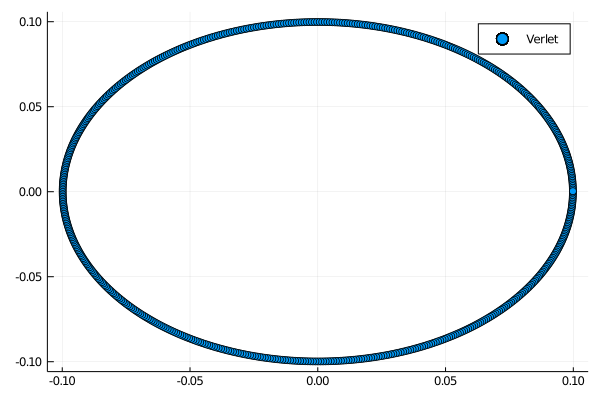

In [26]:
using ForwardDiff

h = 0.01
q0 = [0.01:h:4π;]
q0 = sin.(q0)
n = length(q0)
p0 = zeros(n)
lol = zeros(n, n)
lol[diagind(lol)] .= 2
lol[diagind(lol, 1)] .= -1
lol[diagind(lol, -1)] .= -1
lol = 1/(h^2)*lol


Uv_1, tv_1 = verlet_method(r -> -(lol * r), vcat(q0, p0), 0.01, 2π)

plt = plot(0, 0, size(300,300))
scatter!(plt, Uv_1[10,:], Uv_1[10+n,:], label = "Verlet");

@show plt

plt = Plot{Plots.GRBackend() n=2}


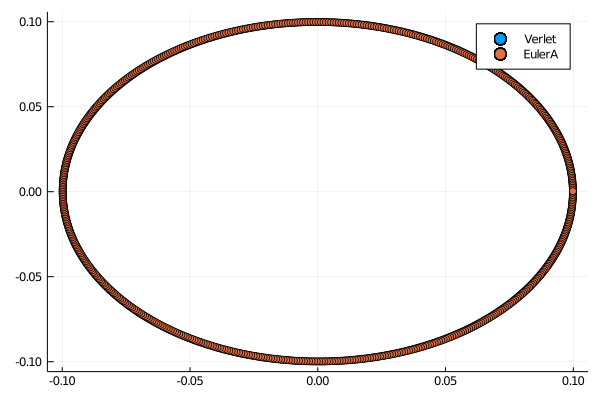

In [27]:
Uv_2, tv_2 = eulerA_method(r -> -(lol * r), vcat(q0, p0), 0.01, 2π)
scatter!(plt, Uv_2[10,:], Uv_2[10+n,:], label = "EulerA");

@show plt

### Other PDEs can be solved by verlet method: The time-independetnt Schördinger Equation
For the time independent Schördinger Equation it can be written as:
$$
E\psi(x)=-\frac{ℏ^2}{2m}\frac{d^2\psi}{x^2}+V(x)\psi(x)
$$
It can be rewritten into the Hamiltonian form as:
$$
\hat{H}=-\frac{ℏ^2}{2m}\frac{d^2\psi}{x^2}+V(x)\psi(x), \qquad \hat{H}\psi(x)=E\psi(x)
$$

This system can be solved using Verlet Method.

**References**

    [1] Overview of Sympletic Integrators: https://aapt.scitation.org/doi/10.1119/1.2034523 
    [2] Hamiltonian System Derivation: https://www.youtube.com/watch?v=FGQddvjP19w
    [3] http://www.crm.umontreal.ca/Comp04/pdf/gni_intro_8.pdf
    [4] http://www.mat.uniroma3.it/users/biasco/Documenti/PhDthesis_digregorio.pdf
    [5] https://young.physics.ucsc.edu/115/leapfrog.pdf